# Green Taxi Tip Analysis
---
Analysis of taxi rider tipping behavior.

## Prepare Data
Import data, create new columns, merge other datasets for additional context on zone and borough information.

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [2]:
# Set the date range
end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Check if 'tripDistance' and 'fareAmount' exist
if 'tripDistance' not in nyc_tlc_df.columns or 'fareAmount' not in nyc_tlc_df.columns:
    print("Columns 'tripDistance' or 'fareAmount' not found. Available columns are:")
    print(nyc_tlc_df.columns)
else:
    # Convert pickup and dropoff datetime to pandas datetime format
    nyc_tlc_df['lpepPickupDatetime'] = pd.to_datetime(nyc_tlc_df['lpepPickupDatetime'])
    nyc_tlc_df['lpepDropoffDatetime'] = pd.to_datetime(nyc_tlc_df['lpepDropoffDatetime'])

    # Extract hour and day of the week from the pickup datetime
    nyc_tlc_df['hour'] = nyc_tlc_df['lpepPickupDatetime'].dt.hour
    nyc_tlc_df['day_of_week'] = nyc_tlc_df['lpepPickupDatetime'].dt.day_name()

    # Extract month and year from the pickup datetime
    nyc_tlc_df['month'] = nyc_tlc_df['lpepPickupDatetime'].dt.month.astype(str)
    nyc_tlc_df['year'] = nyc_tlc_df['lpepPickupDatetime'].dt.year.astype(str)

    # Compute trip duration in minutes
    nyc_tlc_df['trip_duration'] = (nyc_tlc_df['lpepDropoffDatetime'] - nyc_tlc_df['lpepPickupDatetime']).dt.total_seconds() / 60.0

    # Remove rows with zero or negative trip distances and fares for analysis
    nyc_tlc_df = nyc_tlc_df[(nyc_tlc_df['tripDistance'] > 0) & (nyc_tlc_df['fareAmount'] > 0)]

    # Define trip length categories: distance
    bins = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, float('inf')]
    labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    nyc_tlc_df['trip_length_category'] = pd.cut(nyc_tlc_df['tripDistance'], bins=bins, labels=labels, right=False)

    # Define trip length categories: duration
    bins = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, float('inf')]
    labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    nyc_tlc_df['trip_duration_category'] = pd.cut(nyc_tlc_df['trip_duration'], bins=bins, labels=labels, right=False)

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from C:\Users\Megan\AppData\Local\Temp\tmpa5rywrbl\https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2018/puMonth=5/part-00087-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2657-1.c000.snappy.parquet
[Info] read from C:\Users\Megan\AppData\Local\Temp\tmpa5rywrbl\https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2018/puMonth=6/part-00171-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2741-1.c000.snappy.parquet


In [3]:
# Import data on the Taxi Location Codes
zones_df = pd.read_csv('References/taxi_zones.csv')
zones_df['LocationID'] = zones_df['LocationID'].astype('str')

zones = zones_df.drop_duplicates(subset=['LocationID'])

In [4]:
# Add in the zones and boroughs to the dataframe
taxi_df = nyc_tlc_df.copy()

# Add columns that identify the zone and borough of the pick up location
pu_zones = zones.rename(columns={'LocationID': 'puLocationId'})
zone_loc_df = taxi_df.merge(pu_zones, how='left', on='puLocationId')

# Rename pickup zone and borough to be unique
zone_loc_df = zone_loc_df.rename(columns={'zone': 'puZone', 'borough': 'puBorough'})

# Add columns that identify the zone and borough of the drop off location
do_zones = zones.rename(columns={'LocationID': 'doLocationId'})
zone_loc_df = zone_loc_df.merge(do_zones, how='left', on='doLocationId')

# Rename pickup zone and borough to be unique
zone_loc_df = zone_loc_df.rename(columns={'zone': 'doZone', 'borough': 'doBorough'})

# Drop columns not needed for analysis
zone_loc_df = zone_loc_df.drop(columns=['pickupLongitude', 'pickupLatitude', 'dropoffLongitude', 'dropoffLatitude', 'storeAndFwdFlag',
                                        'OBJECTID_x', 'Shape_Leng_x', 'the_geom_x', 'Shape_Area_x', 'OBJECTID_y', 'Shape_Leng_y',
                                        'the_geom_y', 'Shape_Area_y', 'lpepPickupDatetime', 'lpepDropoffDatetime', 'puLocationId',
                                        'doLocationId'])

zone_loc_df.head()

,vendorID,passengerCount,tripDistance,rateCodeID,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,...,day_of_week,month,year,trip_duration,trip_length_category,trip_duration_category,puZone,puBorough,doZone,doBorough
0,2,1,6.73,1,2,26.5,0.0,0.5,0.3,0.0,...,Friday,5,2018,35.266667,5-10,30-40,East Harlem North,Manhattan,Gramercy,Manhattan
1,2,1,0.51,1,2,4.5,0.0,0.5,0.3,0.0,...,Friday,5,2018,3.600000,0-1,2-5,Morningside Heights,Manhattan,Morningside Heights,Manhattan
2,2,1,2.60,1,2,12.0,0.0,0.5,0.3,0.0,...,Friday,5,2018,14.983333,2-5,10-20,Morningside Heights,Manhattan,East Harlem South,Manhattan
3,2,1,3.04,1,2,13.5,0.0,0.5,0.3,0.0,...,Friday,5,2018,18.833333,2-5,10-20,East Harlem South,Manhattan,Manhattanville,Manhattan
4,2,1,1.60,1,2,10.0,0.0,0.5,0.3,0.0,...,Tuesday,5,2018,12.216667,1-2,10-20,Hamilton Heights,Manhattan,Washington Heights North,Manhattan


## Rider Tipping Analysis
Investigate tipping patterns and their variation across different times and locations.

### Tip Analysis by Time of Day and Day of Week

In [7]:
# Group by hour
hour_tip_avg = zone_loc_df.groupby(['trip_length_category','hour'])['tipAmount'].mean().unstack().reindex(index=['0-1', '1-2', '2-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+'])
hour_tip_avg

# Group by day of the week
day_tip_avg = zone_loc_df.groupby(['trip_length_category','day_of_week'])['tipAmount'].mean().unstack().reindex(index=['0-1', '1-2', '2-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+'])

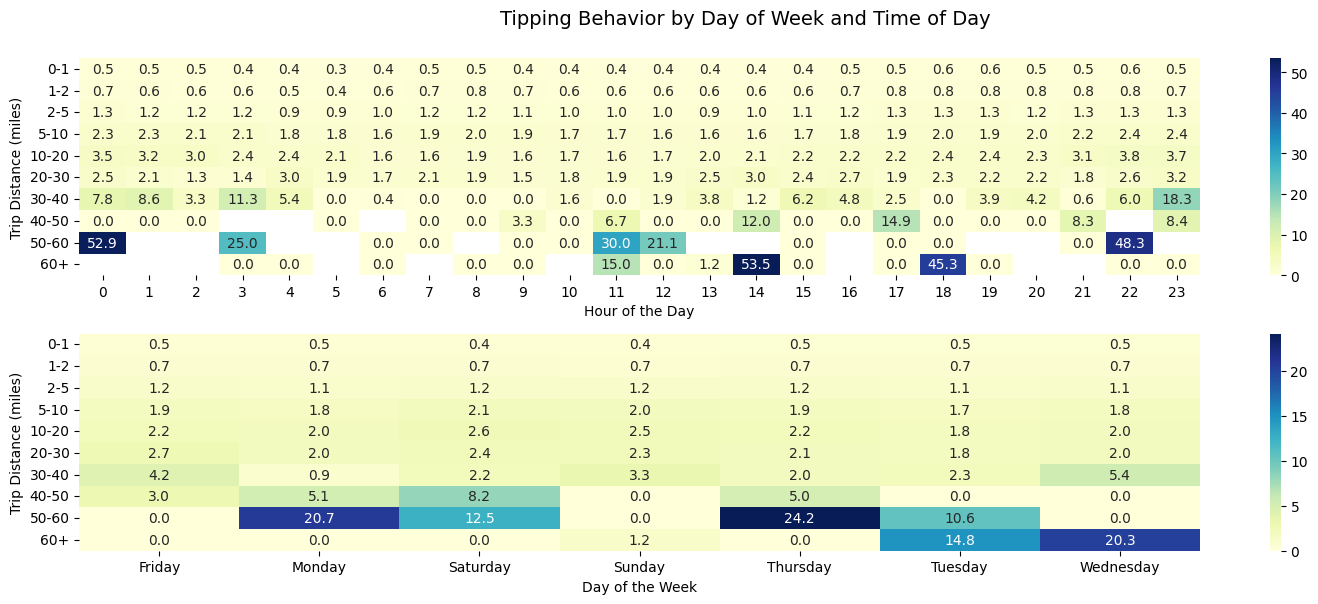

In [8]:
# Plot tipping behavior by day of the week and time of day
plt.figure(figsize=(15,6))

plt.subplot(2, 1, 1)
sns.heatmap(hour_tip_avg, cmap='YlGnBu', annot=True, fmt='.1f')
plt.xlabel('Hour of the Day', size=10)
plt.ylabel('Trip Distance (miles)', size=10)

plt.subplot(2, 1, 2)
sns.heatmap(day_tip_avg, cmap='YlGnBu', annot=True, fmt='.1f')
plt.xlabel('Day of the Week', size=10)
plt.ylabel('Trip Distance (miles)', size=10)

plt.suptitle("Tipping Behavior by Day of Week and Time of Day", y=1, fontsize=14)

# Save the figure
plt.savefig("output_data/Tipping-Behavior-by-Day-of-Week-and-Time-of-Day.png")

plt.tight_layout()
plt.show()

**Discussion of Analysis** Tipping behavior is less impacted by time of day. The day of the week heatmap shows how the average tip increases as the trip length category increases.

In [9]:
# Correlation and regression for tripDistance
(slope, intercept, rvalue, pvalue, stderr) = linregress(zone_loc_df['tripDistance'],zone_loc_df['tipAmount'])

print(f"r-squared: {round(rvalue**2,4)}")
print(f"linear regression model for tip amount: tipAmount = {round(slope,2)}*[tripDistance] + {round(intercept,2)}")

r-squared: 0.0546
linear regression model for tip amount: tipAmount = 0.13*[tripDistance] + 0.61


In [10]:
# Correlation and regression for trip_duration
(slope, intercept, rvalue, pvalue, stderr) = linregress(zone_loc_df['trip_duration'],zone_loc_df['tipAmount'])

print(f"r-squared: {round(rvalue**2,4)}")
print(f"linear regression model for tip amount: tipAmount = {round(slope,2)}*[tripDuration] + {round(intercept,2)}")

r-squared: 0.0004
linear regression model for tip amount: tipAmount = 0.0*[tripDuration] + 1.02


**Discussion of Analysis** Trip duration and distance are not good indicators of what the tip will be.

In [11]:
# Get average tip amount
print(f"average tip amount: ${round(zone_loc_df['tipAmount'].mean(),2)}")

# Check if there is a difference in the tip amount based on the pickup location
puB_tip_byBorough = zone_loc_df.groupby('puBorough')['tipAmount'].mean()
puB_tip_byBorough

average tip amount: $1.03


puBorough
Bronx            0.436615
Brooklyn         1.279874
Manhattan        1.103910
Queens           0.806496
Staten Island    0.603909
Name: tipAmount, dtype: float64

**Discussion of Analysis** Riders that travel longer distances give larger tips on average. In general, riders don't tip too much.